# Tasks
1. From V_in, R, and C generate V_out
1. From V_out generate I_out
1. From V_out and I_out generate Z
1. Match Z with R and C

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import pandas as pd

In [7]:
import panel as pn
import param
pn.extension(sizing_mode="stretch_width", throttled=True)

In [8]:
import session_info
session_info.show()

## Device and Circuit Settings

In [37]:
# Frequency & Amplitude of sin wave
freq = 1000
V_amp = 3.3 / 2

# Desired number of wave oscillations
cycle_num = 2

# Duration of sin wave in seconds
duration = cycle_num / freq 

# Sampling rate of device (samples / sec)
samp_rate = freq * 100

# Input voltage wave
samp_num = int(duration * samp_rate)
t = np.arange(0, duration, duration / samp_num)
V_in = V_amp * np.sin(freq*(2*np.pi*t))

# Resistance in Ohms
R = 10

# Capacitance in Farads
nC = 1000
C = nC * 1e-9

# Ground value of circuit
V_g = 1.65

# Variable resistor of device
Rf = 1000

# Impedance of RC series
Z = complex(R, -1/(freq*C))

# Output current wave

phase = np.angle(- (V_amp / Z)) + np.pi
I_amp = V_amp / abs(Z)

I_out = I_amp * np.sin(freq*(2*np.pi*t) - phase)


# Output voltage wave
V_out = V_in - I_out * Rf
V_out[V_out > 12] = 12
V_out[V_out < -12] = -12

In [38]:
np.max(I_out)

0.0016498350164983505

In [39]:
print("Device parameters:")
print(f"{Rf=}")
print(f"{V_g=}")
print(f"{samp_rate=}")

print("\nWave parameters:")
print(f"{freq=}")
print(f"{V_amp=}")
print(f"{cycle_num=}")
print(f"{duration=}")

print("\nCircuit parameters:")
print(f"{R=}")
print(f"{C=}")
print(f"{Z=}")
print(f"{phase=}")
print(f"{Rf=}")

Device parameters:
Rf=1000
V_g=1.65
samp_rate=100000

Wave parameters:
freq=1000
V_amp=1.65
cycle_num=2
duration=0.002

Circuit parameters:
R=10
C=1.0000000000000002e-06
Z=(10-999.9999999999998j)
phase=1.5607966601082313
Rf=1000


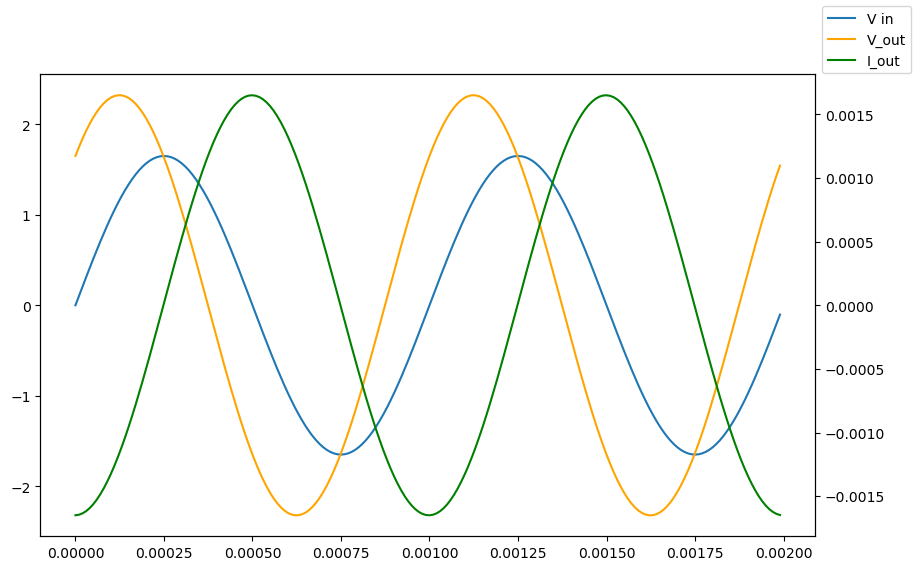

In [40]:
fig, ax = plt.subplots(figsize=(10,6))
ax2 = ax.twinx()
ax.plot(t, V_in, label="V in")
ax.plot(t, V_out, color='orange', label="V_out")
ax2.plot(t, I_out, color='Green', label="I_out")
fig.legend()

V_in_amp=1.6500000000000001
(3.653518250609944e-16-1.6500000000000001j)


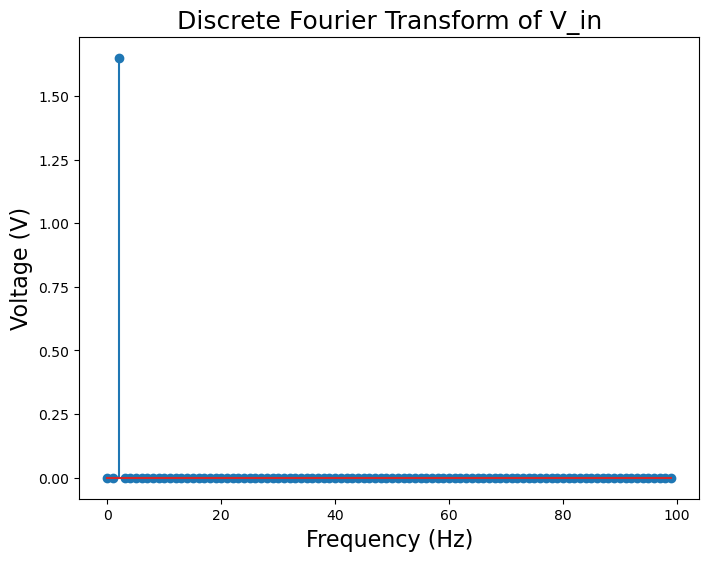

In [19]:
V_in_fft = 2 * np.fft.fft(V_in) / len(V_in)
V_in_fft = V_in_fft[:len(V_in_fft)//2]

V_in_amp = np.max(abs(V_in_fft))
V_crit = np.argmax(abs(V_in_fft))


plt.figure(figsize=(8,6))
plt.title("Discrete Fourier Transform of V_in", size=18)
plt.xlabel("Frequency (Hz)", size=16)
plt.ylabel("Voltage (V)", size=16)
plt.stem(abs(V_in_fft))
print(f"{V_in_amp=}")
print(V_in_fft[V_crit])

/Users/nitinnazeer/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/nitinnazeer/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


NameError: name 'I_out_amp' is not defined

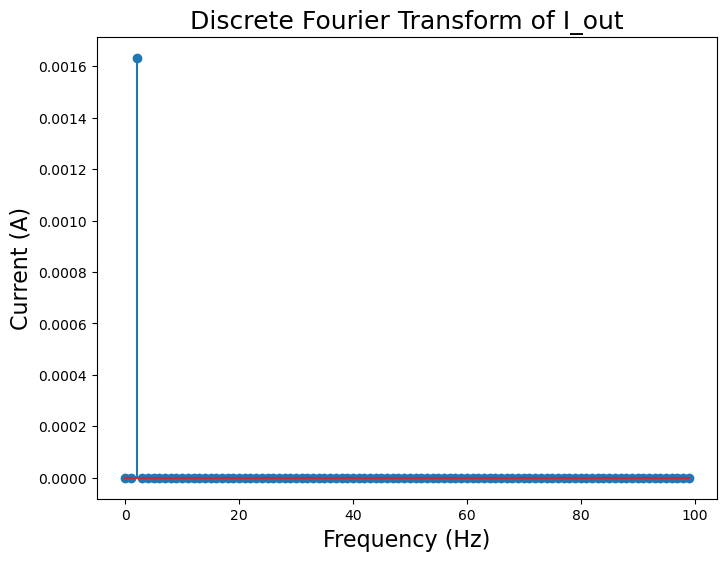

In [15]:
I_out_fft = 2 * np.fft.fft(I_out) / len(I_out)
I_out_fft = I_out_fft[:len(I_out_fft)//2]

I_crit = np.argmax(abs(I_out_fft))
I_amp = I_out_fft[I_crit]

plt.figure(figsize=(8,6))
plt.title("Discrete Fourier Transform of I_out", size=18)
plt.xlabel("Frequency (Hz)", size=16)
plt.ylabel("Current (A)", size=16)
plt.stem(I_out_fft)
print(f"{I_out_amp=}")
print(I_out_fft[I_crit])

In [441]:
# Z_calc = V_in_amp / I_out_amp
Z_calc = V_in_amp / I_out_fft[I_crit]
Z_calc

(1000-100.00000000000041j)

# Servable Web Application

In [41]:
class SimRC(param.Parameterized):
    
    # Amplitude of Input Voltage Wave
    amp = 3.3 / 2
    
    # Frequency & Amplitude of sin wave
    freq = param.Integer(default=1000, bounds=(1, 100000), label="Frequency (Hz)")

    # Desired number of wave oscillations
    cycle_num = param.Integer(default=2, bounds=(1, 10), label="Number of Cycles")

    # Resistance in Ohms
    R = param.Integer(default=100, bounds=(1, 80000), label="Resistance (Ohms)")

    # Capacitance in Nanofarads
    nC = param.Integer(default=1000, bounds=(1, 1000), label="Capacitance (nF)")
    
    # Variable Resistor Rf
    Rf = param.Integer(default=1000, bounds=(1, 80000), label="Feedback Resistor (Ohms)")
    
    # Expected impedance
    Z = -1
    
    # Input Voltage Wave
    V_in = np.array([0])
    
    # Time domain values
    t = np.array([0])
    
    # Output Current Wave
    I_out = np.array([0])
    
    # Output Voltage Wave
    V_out = np.array([0])
    
    V_dft = I_dft = np.array([0])
    V_amp = I_amp = 0
    
    # Calculated Impedance
    Z_calc = -1
    
    @param.depends('freq', 'R', 'nC', watch=True)
    def set_Z(self):
        C = self.nC * 1e-9
        self.Z = complex(self.R, -1/(self.freq*C))
      
    @param.depends('cycle_num', 'freq', 'R', 'nC', 'Rf', watch=True)
    def set_V_in(self):
        # Duration of sin wave in seconds
        duration = self.cycle_num / self.freq

        # Sampling rate of device
        samp_rate = self.freq * 100
        
        samp_num = int(duration * samp_rate)
        self.t = np.arange(0, duration, duration / samp_num)
        self.V_in = self.amp * np.sin(self.freq*(2*np.pi*self.t))
        
    @param.depends('V_in', 'Z', watch=True)
    def set_I_out(self):
        
        phase = np.angle(- (self.amp / self.Z)) + np.pi
        I_amp = self.amp / abs(self.Z)
        self.I_out = I_amp * np.sin(self.freq*(2*np.pi*self.t) - phase)
        
    @param.depends('V_in', 'I_out', watch=True)
    def set_dfts(self):
        
        V_dft = 2 * np.fft.fft(self.V_in) / len(self.V_in)
        self.V_dft = V_dft[:len(V_dft)//2]
        self.V_amp = np.max(abs(self.V_dft))
        
        I_dft = 2 * np.fft.fft(self.I_out) / len(self.I_out)
        self.I_dft = I_dft[:len(I_dft)//2]
        I_crit = np.argmax(abs(self.I_dft))
        self.I_amp = self.I_dft[I_crit]
        
        self.Z_calc = self.V_amp / self.I_amp
        self.Z_calc = complex(-self.Z_calc.imag, -self.Z_calc.real)
        
    @param.depends('Rf', 'V_in', 'I_out', watch=True)
    def set_V_out(self):
        self.V_out = self.V_in - self.I_out * self.Rf
        self.V_out[self.V_out > 12] = 12
        self.V_out[self.V_out < -12] = -12
            

    @param.depends('Z')
    def view_Z(self):
        return pn.pane.Markdown(f"#### Expected Impedance: {self.Z}")
    
    @param.depends('V_in', 'I_out')
    def view_Z_calc(self):
        return pn.pane.Markdown(f"#### Calculated Impedance: {self.Z_calc}")
    
    @param.depends('V_in', 'I_out', 'V_out')
    def view_plots(self):
        df = pd.DataFrame()
        df["Time (Sec)"] = pd.Series(self.t)
        df["Voltage In (V)"] = pd.Series(self.V_in)
        df["Current (A)"] = pd.Series(self.I_out)
        df["Voltage Out (V)"] = pd.Series(self.V_out)
        
        voltages = df.hvplot(x='Time (Sec)', 
                         y=['Voltage In (V)', 'Voltage Out (V)'],
                        title='Input and Output Voltage',
                        shared_axes=False,
                         height=300, responsive=True)
        current = df.hvplot(x='Time (Sec)', 
                         y='Current (A)', 
                         title='Output Current',
                         subplots=True,
                         shared_axes=False,
                         color="green",
                         height=300, responsive=True)
        return (voltages + current).cols(1)
    
    @param.depends('V_dft', 'I_dft')
    def view_dfts(self):
        
        df = pd.DataFrame()
        df["Voltage Amplitude (V)"] = pd.Series(abs(self.V_dft))
        df["Current Amplitude (A)"] = pd.Series(abs(self.I_dft))
        
        return df.hvplot(y=['Voltage Amplitude (V)', 'Current Amplitude (A)'],
                                 subplots=True,
                                 shared_axes=False,
                                height=300, responsive=True).cols(1)
        
    
    
    

simRC = SimRC()

pn.Row(simRC.param, pn.Column(simRC.view_Z,
                              simRC.view_Z_calc,
                              simRC.view_plots,
                              simRC.view_dfts)
      )

Row(sizing_mode='stretch_width')
    [0] Column(margin=5, name='SimRC', sizing_mode='stretch_width', width=300)
        [0] StaticText(sizing_mode='stretch_width', value='<b>SimRC</b>')
        [1] IntSlider(end=100000, name='Frequency (Hz)', sizing_mode='stretch_width', start=1, value=1000)
        [2] IntSlider(end=10, name='Number of Cycles', sizing_mode='stretch_width', start=1, value=2)
        [3] IntSlider(end=80000, name='Resistance (Ohms)', sizing_mode='stretch_width', start=1, value=100)
        [4] IntSlider(end=1000, name='Capacitance (nF)', sizing_mode='stretch_width', start=1, value=1000)
        [5] IntSlider(end=80000, name='Feedback Resistor (..., sizing_mode='stretch_width', start=1, value=1000)
    [1] Column(sizing_mode='stretch_width')
        [0] ParamMethod(method, _pane=Markdown, sizing_mode='stretch_width')
        [1] ParamMethod(method, _pane=Markdown, sizing_mode='stretch_width')
        [2] ParamMethod(method, _pane=HoloViews, sizing_mode='stretch_width')
        [3] ParamMethod(method, _pane=HoloViews, sizing_mode='stretch_width')

In [13]:
# Serve the web application
bootstrap = pn.template.BootstrapTemplate(title="SimRC")

bootstrap.sidebar.append(simRC.param)

message = pn.pane.Markdown("""
    # RC Circuit Impedance Software v1.0
    
    <font size=4>A Fourier Transform implementation that enables reliable impedance calculations on input voltage waveforms.</font>

    #### This software will be helpful if:
    * <font size=4>You want to simulate input voltage and output current waveform readings on a simulated RC circuit</font>
    * <font size=4>You require high-accuracy impedance readings given raw input voltage and output current data</font>

    #### Instructions
    * <font size=4>Use the sliders on the sidebar to change input voltage frequency, number of analyzed cycles,
    the resistance, and the capacitance of the RC circuit. By default, the voltage amplitude is 1.65 volts.</font>
    * <font size=4>Don't forget the capacitance is in nanofarads (nF)! You can collapse this cell using the arrow
    in the upper left corner.</font>

    #### Contact

    <font size=4>If you would like to contact me, please reach out at <nitin.nazeer@gmail.com>. I will try to best to respond to all emails.</font>

    #### License

    <font size=4>This project holds the [GNU Affero General Public License](https://www.gnu.org/licenses/agpl-3.0.en.html). All modifications must attain this license
    and remain open-source.</font>
""")

m_card = pn.Card(message)

Z_card = pn.Card(simRC.view_Z, simRC.view_Z_calc)

plots = pn.Column(
          simRC.view_plots,
          simRC.view_dfts)

bootstrap.main.append(m_card)
bootstrap.main.append(Z_card)
bootstrap.main.append(plots)

bootstrap.servable()

BootstrapTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [140546671685392] Column(margin=5, name='SimRC', sizing_mode='stretch_width', width=300)
        [0] StaticText(sizing_mode='stretch_width', value='<b>SimRC</b>')
        [1] IntSlider(end=100000, name='Frequency (Hz)', sizing_mode='stretch_width', start=1, value=1)
        [2] IntSlider(end=10, name='Number of Cycles', sizing_mode='stretch_width', start=1, value=1)
        [3] IntSlider(end=80000, name='Resistance (Ohms)', sizing_mode='stretch_width', start=1, value=1)
        [4] IntSlider(end=1000, name='Capacitance (nF)', sizing_mode='stretch_width', start=1, value=1)
        [5] IntSlider(end=80000, name='Feedback Resistor (..., sizing_mode='stretch_width', start=1, value=1)
    [140546671683808] Card(margin=(10, 5), sizing_mode='stretch_width')
        [0] Markdown(str, margin=(10, 10), sizing_mode='stretch_width')
    [140546671685248] Card(margin=(10, 5), sizing_mode='stretch_width')
        [0] ParamMethod(method, _pane=Markdown, margin=(10, 10), sizing_mode='stretch_width')
        [1] ParamMethod(method, _pane=Markdown, margin=(10, 10), sizing_mode='stretch_width')
    [140546671683280] Column(sizing_mode='stretch_width')
        [0] ParamMethod(method, _pane=HoloViews, sizing_mode='stretch_width')
        [1] ParamMethod(method, _pane=HoloViews, sizing_mode='stretch_width')

In [ ]:
class Example(param.Parameterized):
    a = param.Integer(default=1, bounds=(1, 10), doc="A Value")
    b = param.Integer(default=2, bounds=(1, 10))
    c = param.Integer(default=3, bounds=(1, 10))
    d = param.Integer(default=4, bounds=(1, 10))
    e = None

    @param.depends('a', 'b', watch=True)
    def c_update(self):
        self.c = self.a + self.b
        
    @param.depends('a', 'c', watch=True)
    def e_update(self):
        self.e = np.arange(self.a, self.c)
        
    @param.depends('c', 'e')
    def plot(self):
        fig, ax = plt.subplots()
        ax.plot(self.e)
        plt.close()
        return fig
        

In [ ]:
ex = Example()
ex.a = 5
ex.e = np.arange(ex.a, ex.c)

In [ ]:
ex.c = 10
print(f"{ex.a=}")
print(f"{ex.c=}")
print(f"{ex.e=}")

In [ ]:
pn.Column(ex.param, ex.plot)

In [20]:
a = 5
b = complex(3, 4)

a / b

(0.6-0.8j)

In [106]:
freq = 5
shift = -np.pi

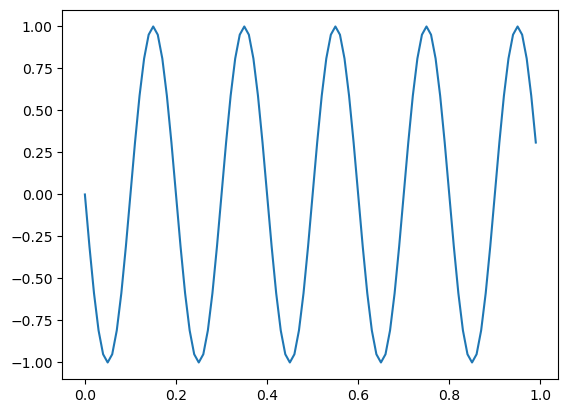

In [107]:
t = np.arange(0, 1, 0.01)
V = np.sin(freq*(2*np.pi*t) - shift)
plt.plot(t, V)

In [294]:
start = 0
end = 4
cnt = 8
step = end / cnt
np.arange(start, end, step)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5])